In [5]:
import pyaudio
import numpy as np
import struct
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('GTKAgg') # matplotlib animation api

In [6]:
threshold = 40
rate = 44100
input_block_time = 0.03
input_frames_per_block = int(rate*input_block_time)

In [17]:
def get_rms(block):
    return np.sqrt(np.mean(np.square(block)))

class AudioHandler(object):
    def __init__(self):
        self.pa = pyaudio.PyAudio()
        self.stream = self.open_mic_stream()
        self.threshold = threshold
        self.plot_counter = 0
        
    def stop(self):
        self.stream.close()
        
    def find_input_device(self):
        dev_index = None
        for i in range(self.pa.get_device_count()):
            dev_info = self.pa.get_device_info_by_index(i)
            print('Device %{}: %{}'.format(i, dev_info['name']))
            
            for keyword in ['mic', 'input']:
                if keyword in dev_info['name'].lower():
                    print('Found an input device {} - {}'.format(i, dev_info['name']))
                    dev_index = i
                    return dev_index
                
        if dev_index == None:
            print('No preferred input found => using default input')
            
        return dev_index
    
    def open_mic_stream(self):
        dev_index = self.find_input_device()
        stream = self.pa.open(format = pyaudio.paInt16,
                             channels = 1,
                             rate = rate,
                             input = True,
                             input_device_index = dev_index,
                             frames_per_buffer = input_frames_per_block)
        return stream
    
    def processBlock(self, block):
        f, t, Sxx = signal.spectrogram(block, rate, nperseg=64, nfft=256, noverlap=60)
        dbs = 10*np.log10(Sxx)
        plt.pcolormesh(t, f, dbs)
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.show()
        plt.pause(0.00001)
        
        #plt.savefig('data/spec{}.png'.format(self.plot_counter), bbox_inches='tight')
        #plt.show()
        self.plot_counter += 1
        
    def listen(self):
        try:
            raw_block = self.stream.read(input_frames_per_block, exception_on_overflow = False)
            count = len(raw_block)/2
            format = '%dh' % (count)
            block = np.array(struct.unpack(format, raw_block))
        except Exception as e:
            print('Error recording: {}'.format(e))
            return
        
        amplitude = get_rms(block)
        if amplitude > self.threshold:
            self.processBlock(block)
        else:
            pass

Device %0: %MacBook Pro Microphone
Found an input device 0 - MacBook Pro Microphone


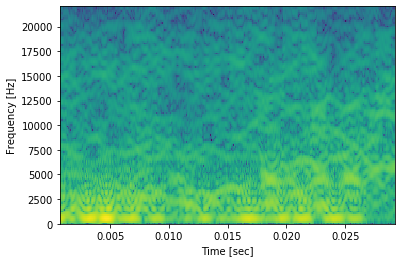

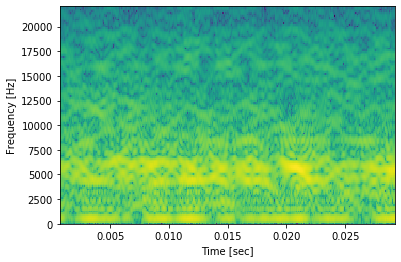

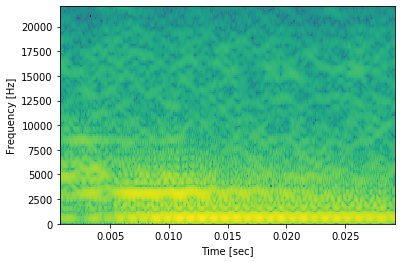

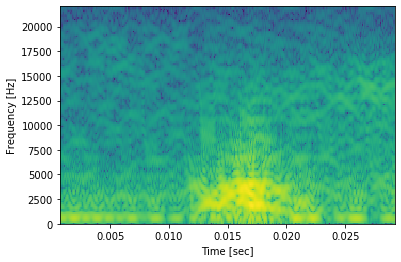

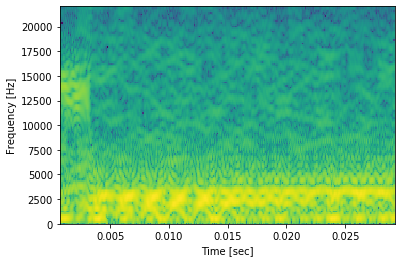

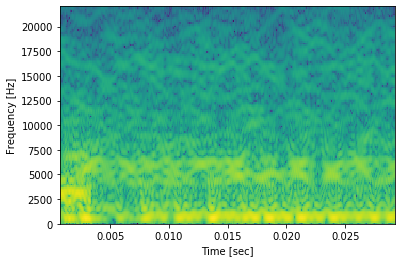

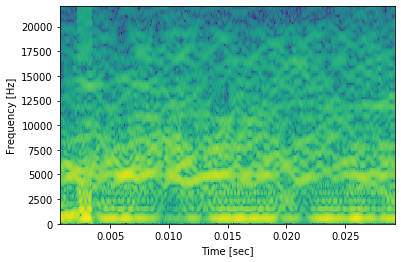

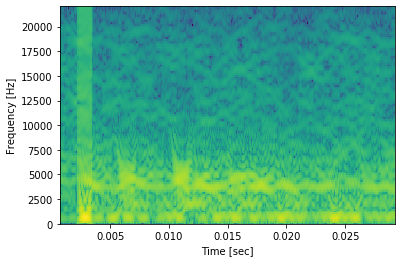

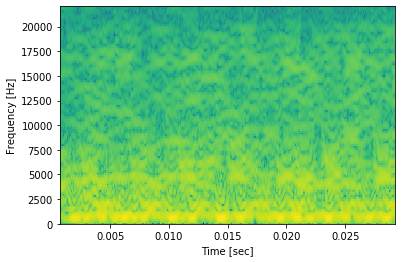

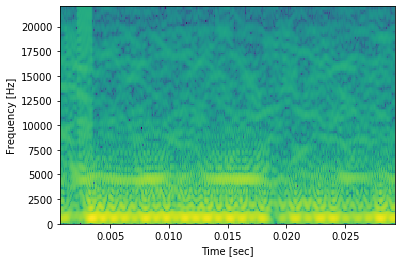

In [18]:
audio = AudioHandler()
for i in range(0,10):
    audio.listen()

In [1]:
import pyaudio
import numpy as np
import struct
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
threshold = 10
rate = 44100
input_block_time = 0.003
input_frames_per_block = int(rate*input_block_time)

In [15]:
def get_rms(block):
    return np.sqrt(np.mean(np.square(block)))

class AudioHandler(object):
    def __init__(self):
        self.pa = pyaudio.PyAudio()
        self.stream = self.open_mic_stream()
        self.threshold = threshold
        self.spec = np.zeros((513,128), dtype=float)
        print(self.spec.shape)

    def stop(self):
        self.stream.close()
        
    def find_input_device(self):
        dev_index = None
        for i in range(self.pa.get_device_count()):
            dev_info = self.pa.get_device_info_by_index(i)
            print('Device %{}: %{}'.format(i, dev_info['name']))
            
            for keyword in ['mic', 'input']:
                if keyword in dev_info['name'].lower():
                    print('Found an input device {} - {}'.format(i, dev_info['name']))
                    dev_index = i
                    return dev_index
                
        if dev_index == None:
            print('No preferred input found => using default input')
            
        return dev_index
    
    def open_mic_stream(self):
        dev_index = self.find_input_device()
        stream = self.pa.open(format = pyaudio.paInt16,
                             channels = 1,
                             rate = rate,
                             input = True,
                             input_device_index = dev_index,
                             frames_per_buffer = input_frames_per_block)
        return stream
    
    def spectro_process(self, block):
        f, t, Sxx = signal.spectrogram(block, rate, window=('kaiser',14), nperseg=128, nfft=1024, noverlap=64)
        #f, t, Sxx = signal.spectrogram(block, rate, nperseg=128, nfft=512, noverlap=100)
        #f, t, Sxx = signal.spectrogram(block, rate)
        plt.clf()
        plt.pcolormesh(t, f, Sxx, cmap='inferno')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.pause(0.00001)
    
    def fft_process(self, block):
        freq = np.absolute(np.fft.rfft(block, n=1024))
        self.spec = np.roll(self.spec, -1, axis=1)
        self.spec[:,-1] = freq
        
        plt.clf()
        plt.pcolormesh(self.spec, cmap='inferno')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.pause(0.00001)

    def listen(self):
        try:
            raw_block = self.stream.read(input_frames_per_block, exception_on_overflow = False)
            count = len(raw_block)/2
            format = '%dh' % (count)
            block = np.array(struct.unpack(format, raw_block))
        except Exception as e:
            print('Error recording: {}'.format(e))
            return
        
        amplitude = get_rms(block)
        if amplitude > self.threshold:
            self.fft_process(block)
        else:
            pass

Device %0: %MacBook Pro Microphone
Found an input device 0 - MacBook Pro Microphone
(513, 128)


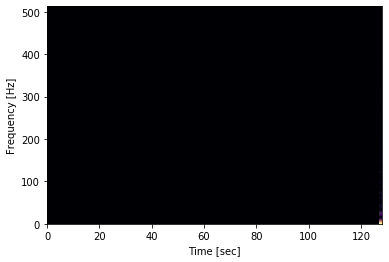

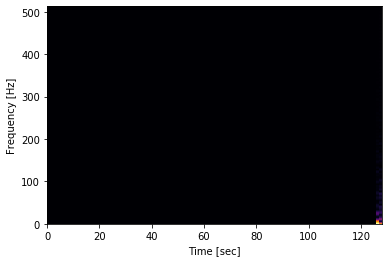

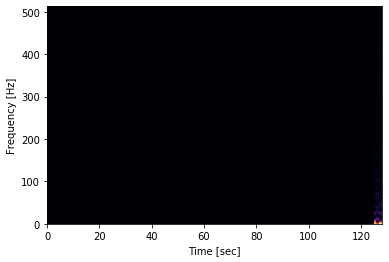

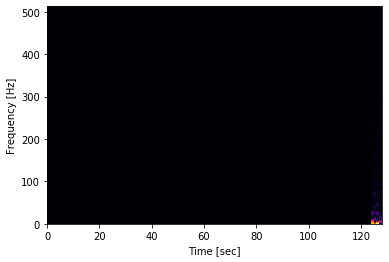

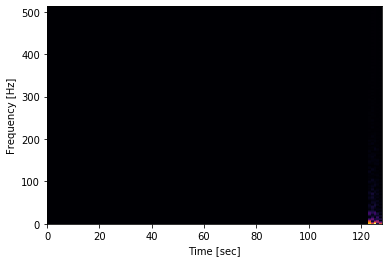

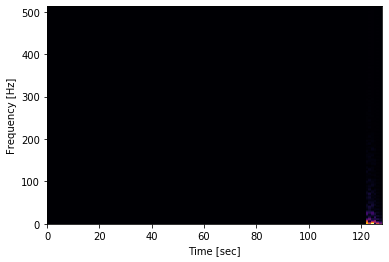

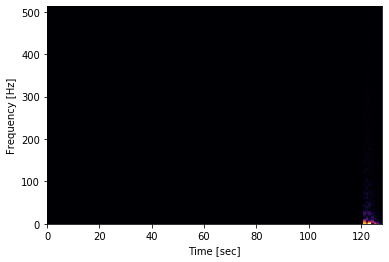

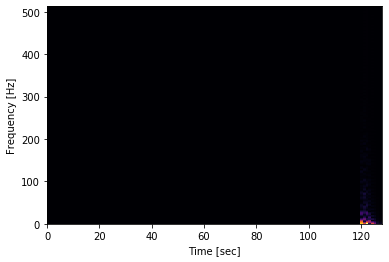

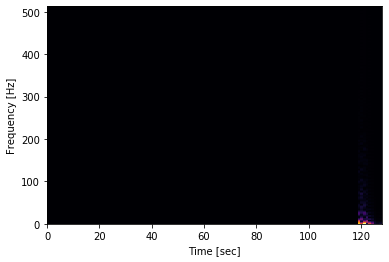

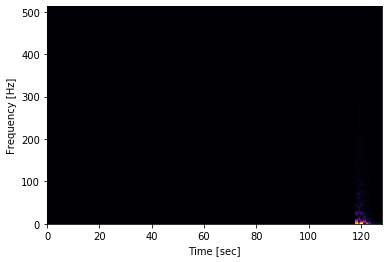

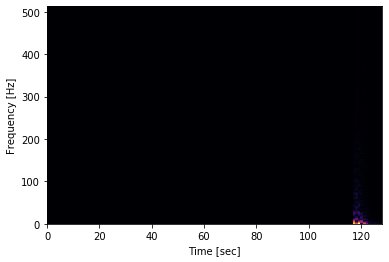

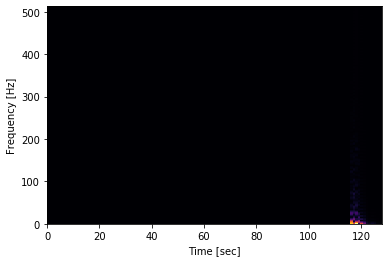

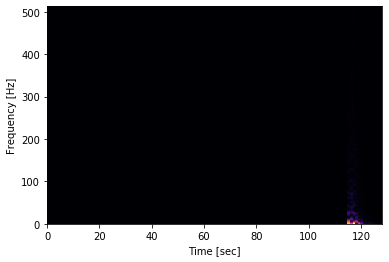

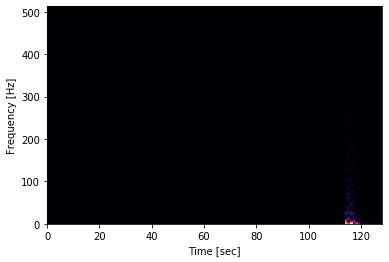

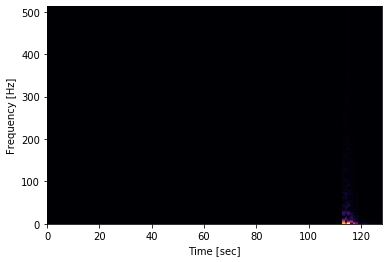

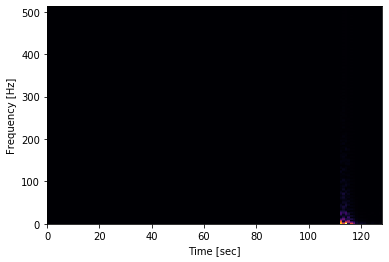

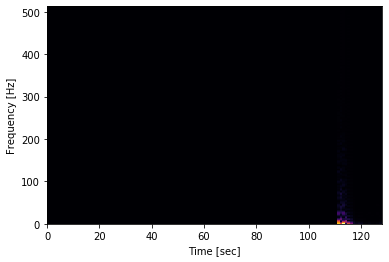

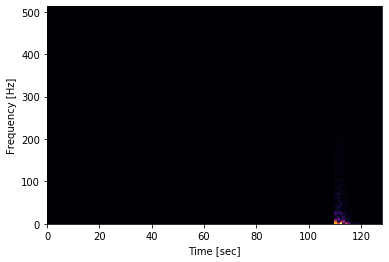

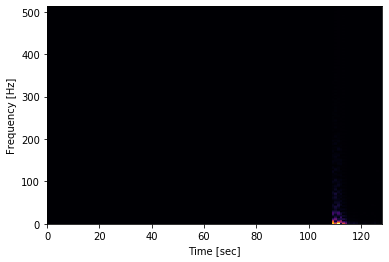

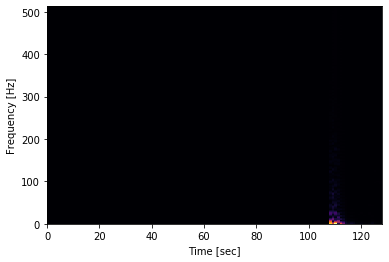

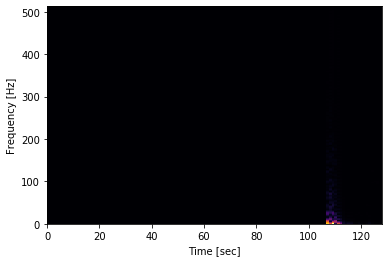

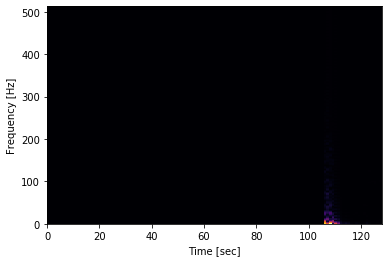

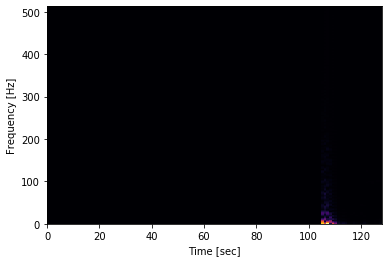

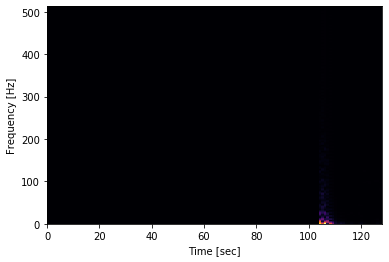

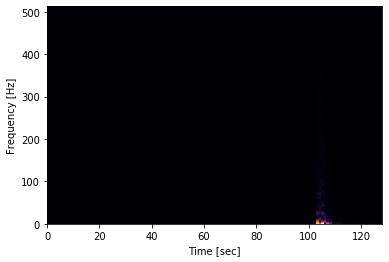

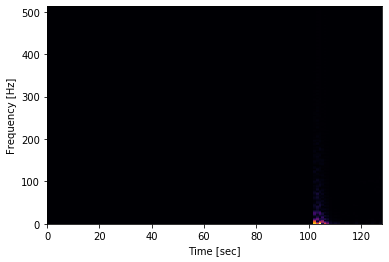

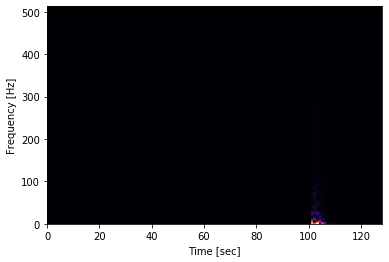

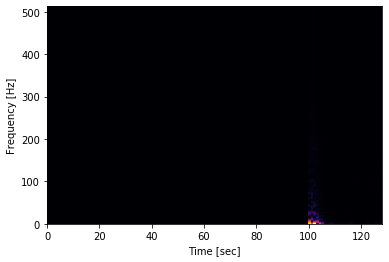

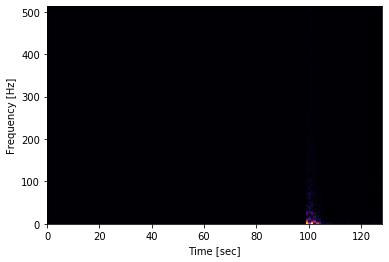

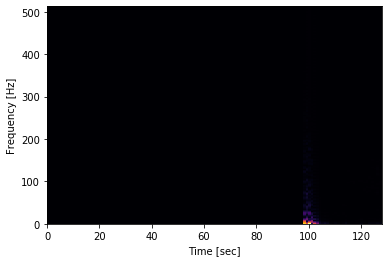

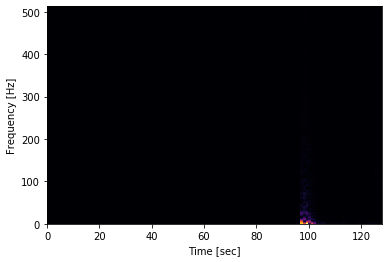

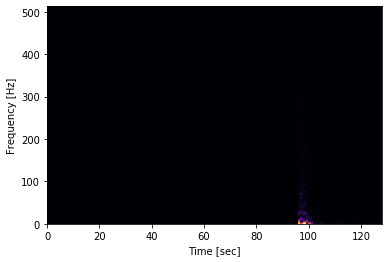

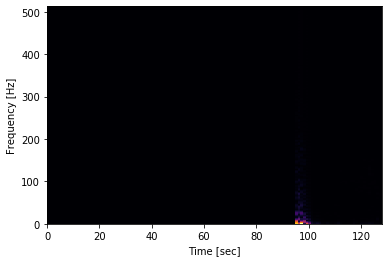

In [ ]:
audio = AudioHandler()
try:
    while True:
        audio.listen()
except KeyboardInterrupt:
    audio.stop()

In [10]:
a = np.array([[1,2,3],[4,5,6]])
b = np.zeros(a.shape)
print(a.shape)

(2, 3)


In [14]:
print(a)
a = np.roll(a, -1, axis=1)
print(a)
a[:,2] = np.array([9,8])
print(a)

[[2 3 1]
 [5 6 4]]
[[3 1 2]
 [6 4 5]]
[[3 1 9]
 [6 4 8]]
